# Notebook 4001: $\Gamma_\mathrm{switch}$ fits

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 4001

#### Imports, constants & data

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
import astropy.constants as ct
import astropy.units as u
import mesa_reader as mr

import sys
sys.path.append('..')
from src.util import (savefig_base, get_model_folder_base, get_model_dict, fix_unit)
plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [3]:
Z_SUN = 0.02 # same as Sabhahit et al. (2023)

In [4]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')

FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
def savefig(*args, **kwargs): 
    savefig_base(*args, nb_id=nb_id, figure_folder=FIGURE_FOLDER, **kwargs)
    
def get_model_folder(*args, **kwargs):
    return get_model_folder_base(PROJECT_FOLDER, *args, **kwargs)

#### References
Backs, F., Brands, S. A., Koter, A. de, et al. 2024 (arXiv), http://arxiv.org/abs/2411.06884  
Bestenlehner, J. M. 2020, Monthly Notices of the Royal Astronomical Society, 493, 3938  
Björklund, R., Sundqvist, J. O., Singh, S. M., Puls, J., & Najarro, F. 2023, A&A, 676 (EDP Sciences), A109  
Heger, A., Langer, N., & Woosley, S. E. 2000, ApJ, 528 (IOP Publishing), 368  
Krtička, J., & Kubát, J. 2017, Astronomy and Astrophysics, 606, A31  
Krtička, J., & Kubát, J. 2018, A&A, 612 (EDP Sciences), A20  
Krtička, J., Kubát, J., & Krtičková, I. 2018, Astronomy and Astrophysics, 620, A150  
Krtička, J., Kubát, J., & Krtičková, I. 2021, Astronomy and Astrophysics, 647, A28  
Krtička, J., Kubát, J., & Krtičková, I. 2024, A&A, 681 (EDP Sciences), A29  
Leitherer, C., Robert, C., & Drissen, L. 1992, The Astrophysical Journal, 401 (IOP), 596  
Sabhahit, G. N., Vink, J. S., Sander, A. A. C., & Higgins, E. R. 2023, Monthly Notices of the Royal Astronomical Society, 524, 1529  
Sander, A. a. C., Lefever, R. R., Poniatowski, L. G., et al. 2023, A&A, 670, A83  
Sander, A. A. C., & Vink, J. S. 2020, Monthly Notices of the Royal Astronomical Society, 499, 873  
Sander, A., Shenar, T., Hainich, R., et al. 2015, Astronomy and Astrophysics, 577, A13  
Tsuna, D., & Lu, W. 2025 (arXiv), http://arxiv.org/abs/2501.03316  
Verhamme, O., Sundqvist, J., de Koter, A., et al. 2024, Astronomy and Astrophysics, 692 (EDP), A91  
Vink, J. S. 2017, A&A, 607, L8  
Vink, J. S., de Koter, A., & Lamers, H. J. G. L. M. 2001, Astronomy and Astrophysics, 369, 574  
Vink, J. S., Muijres, L. E., Anthonisse, B., et al. 2011, A&A, 531 (EDP Sciences), A132  


In [6]:
def edd_gamma(l, m, x):
    return 10**-4.817 * (1+x) * l/m


In [7]:
def vink2001_w(l, m, teff, z):
    t_jump = 61.2 + 2.59*(-13.636+0.889*np.log10(z/Z_SUN))
    dt_jump = 100
    
    if teff > 27.5e3:
        a = 1
    elif teff < 22.5e3:
        a = 0
    else:
        if teff > t_jump+dt_jump:
            a = 1
        elif teff < t_jump-dt_jump:
            a = 0
        else:
            a = (teff-(t_jump-dt_jump))/(2*dt_jump)
    
    if a > 0:
        vinf_div_vesc = 2.6*(z/Z_SUN)**0.13
        log_mdot = (-6.697
                    +2.194*np.log10(l/1e5)
                    -1.313*np.log10(m/30)
                    -1.226*np.log10(vinf_div_vesc/2)
                    +0.933*np.log10(teff/4e4)
                    -10.92*np.log10(teff/4e4)**2
                    +0.85*np.log10(z/Z_SUN))
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
    
    if a < 1:
        vinf_div_vesc = 1.3*(z/Z_SUN)**0.13
        log_mdot = (-6.688
                    +2.210*np.log10(l/1e5)
                    -1.339*np.log10(m/30)
                    -1.601*np.log10(vinf_div_vesc/2)
                    +1.07*np.log10(teff/4e4)
                    +0.85*np.log10(z/Z_SUN))
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0

    w = a*mdot1 + (1-a)*mdot2
    return w

In [8]:
def krticka2024_w(l, teff, z):
    a = -13.82
    b = 1.52
    c = 3.84
    t1 = 14.16e3
    t2 = 37.9e3
    dt1 = 3.58e3
    dt2 = 56.5e3
    alpha = 0.358
    beta = -0.11
    delta = 0.73
    log_z_div_z_sun = np.log10(z/Z_SUN)
    
    log_lin_comp = (a
                    + alpha * log_z_div_z_sun
                    + (b + beta * log_z_div_z_sun) * np.log10(l/1e6))
    gauss_mix_comp = ((1 + delta * log_z_div_z_sun) * np.exp(-(teff-t1)**2/dt1**2)
                      + c * np.exp(-(teff-t2)**2/dt2**2))
    log_mdot = log_lin_comp - a * np.log10(gauss_mix_comp)
    w = 10.**log_mdot
    return w

In [9]:
def bjorklund2023_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    meff = (1-g_e)*m
    log_mdot = (-5.52
                +2.39*np.log10(l/1e6)
                -1.48*np.log10(meff/45)
                +2.12*np.log10(teff/4.5e4)
                +(0.75
                  -1.87*np.log10(teff/4.5e4)) * np.log10(z/Z_SUN))
    w = 10.**log_mdot 
    return w

In [10]:
def vink2011_w(l, m, t, z, x, m_switch=None, g_switch=0.7):
    if m_switch is None:
        m_switch = m
    v01_w = vink2001_w(l, m, t, z)
    g_e = edd_gamma(l, m, x)
    
    if g_e <= g_switch:
        w = v01_w
    else:
        w = v01_w * (m/m_switch)**0.78 * (g_e/g_switch)**4.77
        
    return w

In [11]:
def s23_v_ter(l, m, r, z, x):
    l = fix_unit(l, u.Lsun)
    m = fix_unit(m, u.Msun)
    r = fix_unit(r, u.Rsun)
    g_e = edd_gamma(l.value, m.value, x)
    v_ter = (2.6
             * np.sqrt(2*ct.G*m * (1-g_e) / r)
             * (z/Z_SUN)**0.2)
    return v_ter.cgs.value

def s23_vter_div_vesc(l, m, z, x):
    g_e = edd_gamma(l, m, x)
    ratio = 2.6 * np.sqrt(1-g_e) * (z/Z_SUN)**0.2
    return ratio

def s23_wind_eff(l, m, r, mdot, z, x):
    l = fix_unit(l, u.Lsun)
    m = fix_unit(m, u.Msun)
    r = fix_unit(r, u.Rsun)
    mdot = fix_unit(mdot, u.Msun/u.yr)
    v_ter = s23_v_ter(l, m, r, z ,x) * u.cm/u.s
    wind_eff = v_ter*mdot / (l/ct.c)
    return wind_eff.to(u.dimensionless_unscaled).value

def s23_eta_switch(l, m, z, x):
    g_e = edd_gamma(l, m, x)
    eta_switch = 0.75 / (
        1 + 1/(6.76 * (1-g_e)) * (z/Z_SUN)**-0.4
    )
    return eta_switch

def s23_vink2001_w(l, m, z, x):
    #vinf_div_vesc = 2.6*(z/Z_SUN)**0.13 # original V01 scaling
    vinf_div_vesc = 2.6*(z/Z_SUN)**0.20 # updated scaling
    #vinf_div_vesc = s23_vter_div_vesc(l, m, z, x) # why do they not use their own expression for the ratio?
    log_mdot = (-6.697
                +2.194*np.log10(l/1e5)
                -1.313*np.log10(m/30)
                -1.226*np.log10(vinf_div_vesc/2)
                +0.85*np.log10(z/Z_SUN)) # no Teff terms
    mdot = 10.**log_mdot

    return mdot

In [12]:
def grafener_l_to_m_h_burning(l, x):
    """Equations 11, 12 from Gräfener et al. (2011).
    
    From relations 11, 12 and 13 in Table A.1 Switch at logL=6.5 is from
    Sabhahit et al. (2023).
    """
    
    FF11 = [4.026, 4.277, -1.0, 25.48, 36.93, -2.792, -3.226, -5.317, 1.648]
    FF12 = [2.582, 0.829, -1.0, 9.375, 0.333, 0.543, -1.376, -0.049, 0.036] 
    FF13 = [10.05, 8.204, -1.0, 151.7, 254.5, -11.46 ,-13.16, -31.68, 2.408]

    if l < 10.**6.5:
        FF = FF11
    else:
        FF = FF13
    f = FF[3] + FF[4]*x + FF[5]*x*x + (FF[6] + FF[7]*x) * np.log10(l)
    logm = (FF[0] + FF[1]*x + FF[2]*np.sqrt(f)) / (1 + FF[8]*x)
    m  = 10.**logm
  
    return m

def grafener_m_to_l_h_burning(m, x):
    """Equation 9 from Gräfener et al. (2011).
    
    From relations 1, 1 and 1 in Table A.1 Switch at logL=6.5 is from
    Sabhahit et al. (2023).
    """
    FF1 = [2.875, -3.966, 2.496, 2.652, -0.310, -0.511]
    FF2 = [1.967, -2.943, 3.755, 1.206, -0.727, -0.026]
    FF3 = [3.862, -2.486, 1.527, 1.247, -0.076, -0.183]
    
    FF = FF1
    log_l = (FF[0] + FF[1]*x
             + (FF[2] + FF[3]*x) * np.log10(m)
             + (FF[4] + FF[5]*x) * np.log10(m)**2)
    if log_l > 6.5:
        FF = FF3
        log_l = (FF[0] + FF[1]*x
             + (FF[2] + FF[3]*x) * np.log10(m)
             + (FF[4] + FF[5]*x) * np.log10(m)**2)
    return 10.**log_l

def grafener_l_to_m_he_burning(l):
    """Equation 18 from Gräfener et al. (2011).
    
    From relations 17, 16 and 18 in Table A.1 Switch at logL=6.5 is from
    Sabhahit et al. (2023).
    """
    
    FF = [8.177, -1.0, 105.5, -10.10] # 18
    #FF = [3.997, -1.0, 25.83, -3.268] # 16
    #FF = [3.059, -1.0, 14.76, -2.049] # 17
    logm = FF[0] + FF[1] * np.sqrt(FF[2] + FF[3] * np.log10(l))
    return 10.**logm

def grafener_m_to_l_he_burning(m):
    """Equation 10 from Gräfener et al. (2011).
    
    From relations 6, 7, and 8 in Table A.1 Switch at logL=6.5 is from
    Sabhahit et al. (2023).
    """
    #FF = [3.017, 2.446, -0.306] # 6
    #FF = [3.017, 2.446, -0.306] # 7
    FF = [3.826, 1.619, -0.099] # 8
    log_l = FF[0] + FF[1]*np.log10(m) + FF[2]*np.log10(m)**2
    return 10.**log_l

In [13]:
def sb_radius(l, teff):
    l = fix_unit(l, u.Lsun)
    teff = fix_unit(teff, u.K)
    r = np.sqrt(l/(4*np.pi*ct.sigma_sb*teff**4)).to(u.Rsun)
    return r.value

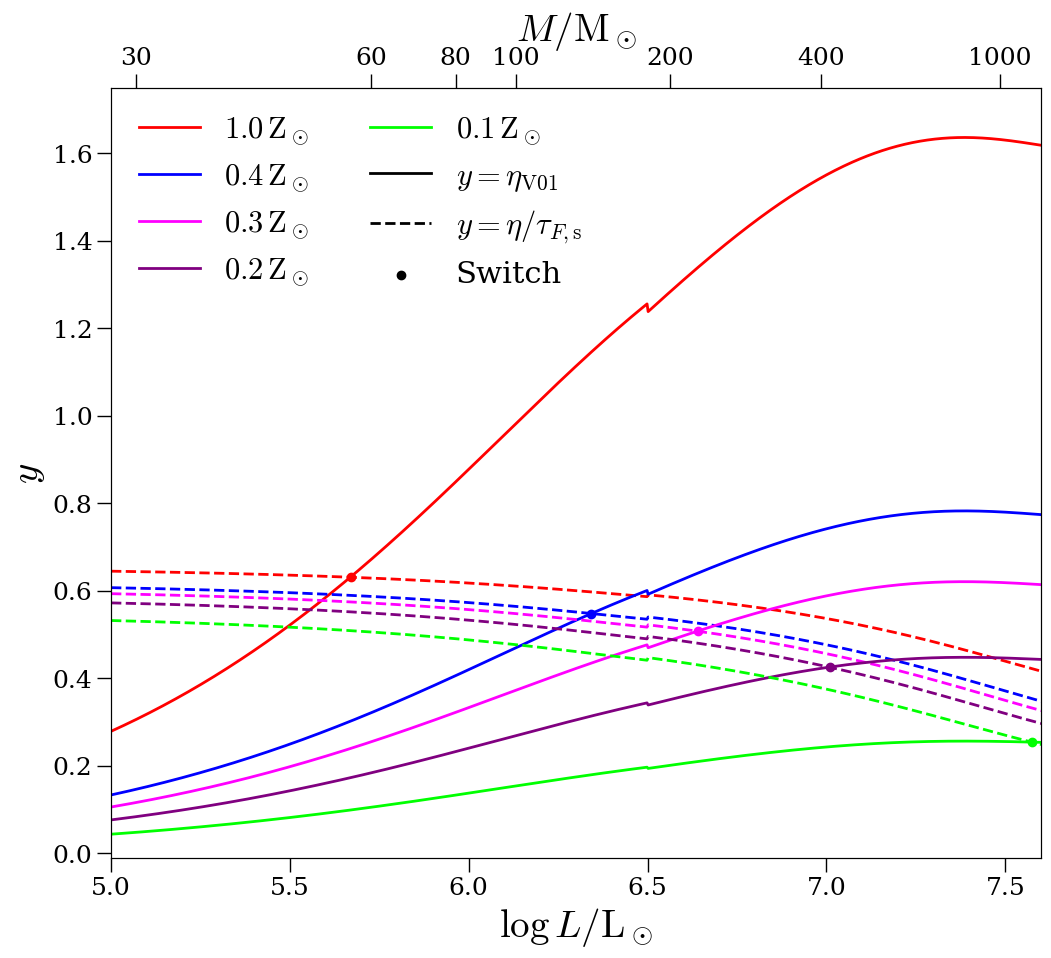

In [14]:
switch_plot_len = 1000
zbase = Z_SUN
test_zs = [zbase, zbase*0.4, zbase*0.3, zbase*0.2, zbase*0.1]
z_cs = ['red', 'blue', 'magenta', 'purple', 'lime']

switch_plot_t = np.tile([45000], switch_plot_len)
switch_plot_x = np.tile([0.7], switch_plot_len)

switch_plot_l = np.logspace(5, 8, switch_plot_len)
switch_plot_m = np.array([grafener_l_to_m_h_burning(l, x) for l, x in zip(switch_plot_l, switch_plot_x)])

fig, ax = plt.subplots(figsize=(12, 10))
x = np.log10(switch_plot_l)
for z,c  in zip(test_zs, z_cs):
    switch_plot_z = np.tile([z], switch_plot_len)

    switch_plot_mdot = np.array([
        s23_vink2001_w(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])
    switch_plot_r = np.array([
        sb_radius(l, t) for l, t in zip(switch_plot_l, switch_plot_t)
    ])
    switch_plot_eta = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_switch = np.array([
        s23_eta_switch(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])

    ax.plot(x, switch_plot_eta, c=c, label=f'${z/Z_SUN:.1f}\,\mathrm{{Z}}_\odot$')
    ax.plot(x, switch_plot_switch, '--', c=c)
    
    switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    switch_y = switch_plot_eta[switch_i]
    ax.scatter(x[switch_i], switch_y, color=c)


ax.set_xlim(5, 7.6)
ax.set_ylim(-0.01, 1.75)
ax.set_yticks(np.arange(0, 1.8, 0.2))

ax.set_xlabel('$\log L/\mathrm{L}_\odot$')
ax.set_ylabel('$y$')

m_ax = ax.twiny()
m_ax.set_xlim(ax.get_xlim())
mticks = [30, 60, 80, 100, 200, 400, 1000]
lticks = [grafener_m_to_l_h_burning(m, switch_plot_x[0]) for m in mticks]
m_ax.set_xticks(np.log10(lticks))
m_ax.set_xticklabels([f'{m:.0f}' for m in mticks])
m_ax.set_xlabel('$M/\\mathrm{M}_\\odot$')

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], color='k', ls='-', label='$y=\\eta_\\mathrm{V01}$'))
handles.append(Line2D([], [], color='k', ls='--', label='$y=\\eta/\\tau_{F,\\mathrm{s}}$'))
handles.append(ax.scatter([], [], color='k', label='Switch'))
ax.legend(handles=handles, frameon=False, ncol=2)

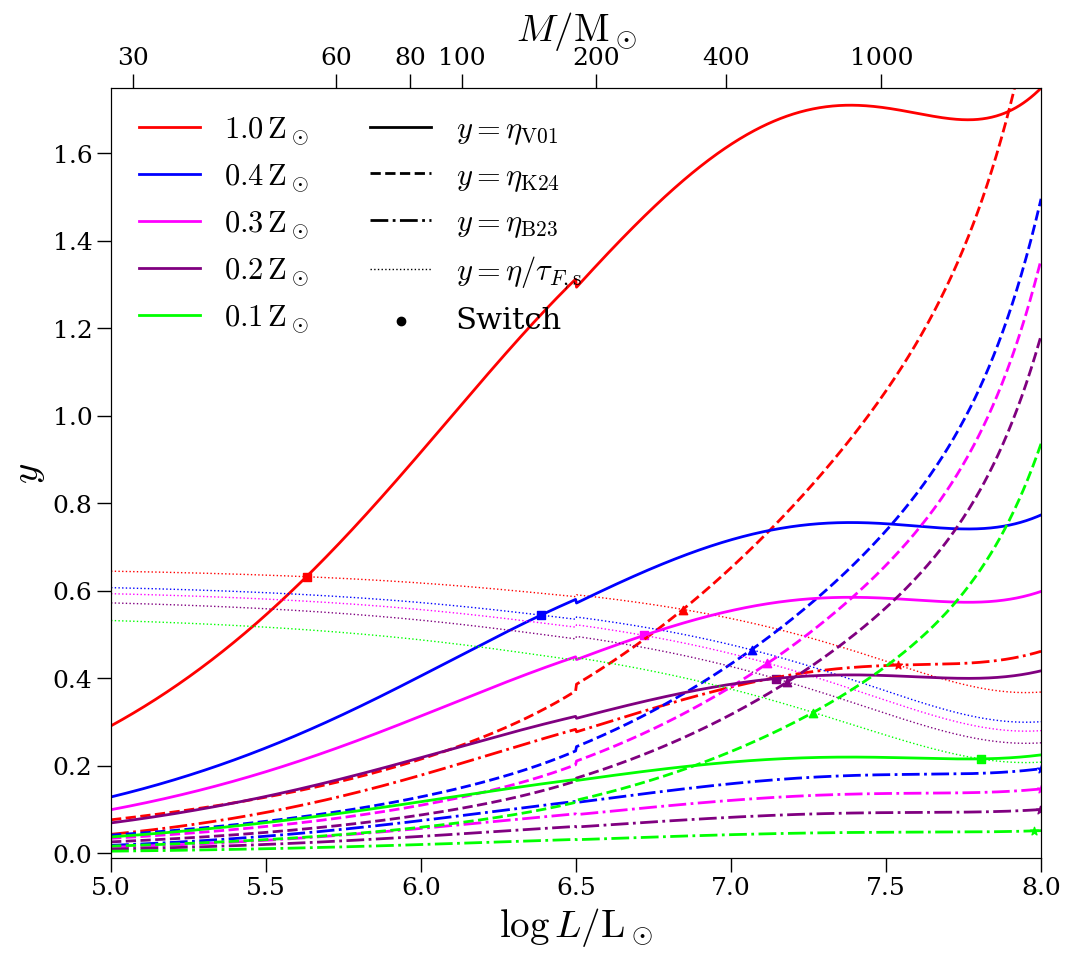

In [15]:
switch_plot_len = 1000
zbase = Z_SUN
test_zs = [zbase, zbase*0.4, zbase*0.3, zbase*0.2, zbase*0.1]
z_cs = ['red', 'blue', 'magenta', 'purple', 'lime']

switch_plot_t = np.tile([45000], switch_plot_len)
switch_plot_x = np.tile([0.7], switch_plot_len)

switch_plot_l = np.logspace(5, 8, switch_plot_len)
switch_plot_m = np.array([grafener_l_to_m_h_burning(l, x) for l, x in zip(switch_plot_l, switch_plot_x)])

fig, ax = plt.subplots(figsize=(12, 10))
x = np.log10(switch_plot_l)
for z,c  in zip(test_zs, z_cs):
    switch_plot_z = np.tile([z], switch_plot_len)

    switch_plot_mdot_v01 = np.array([
        vink2001_w(l, m, t, z) for l, m, t, z in zip(switch_plot_l, switch_plot_m, switch_plot_t, switch_plot_z)
    ])
    switch_plot_mdot_k24 = np.array([
        krticka2024_w(l, t, z) for l, t, z in zip(switch_plot_l, switch_plot_t, switch_plot_z)
    ])
    switch_plot_mdot_b23 = np.array([
        bjorklund2023_w(l, m, t, z, x) for l, m, t, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_t, switch_plot_z, switch_plot_x)
    ])
    switch_plot_r = np.array([
        sb_radius(l, t) for l, t in zip(switch_plot_l, switch_plot_t)
    ])
    switch_plot_switch = np.array([
        s23_eta_switch(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])

    switch_plot_mdot = switch_plot_mdot_v01
    switch_plot_eta_v01 = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_mdot = switch_plot_mdot_k24
    switch_plot_eta_k24 = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_mdot = switch_plot_mdot_b23
    switch_plot_eta_b23 = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])

    ax.plot(x, switch_plot_eta_v01, c=c, ls='-', lw=2, label=f'${z/Z_SUN:.1f}\,\mathrm{{Z}}_\odot$')
    ax.plot(x, switch_plot_eta_k24, c=c, ls='--', lw=2)
    ax.plot(x, switch_plot_eta_b23, c=c, ls='-.', lw=2)
    ax.plot(x, switch_plot_switch, ':', c=c, lw=1)
    
    
    switch_plot_eta = switch_plot_eta_v01
    switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    switch_y = switch_plot_eta[switch_i]
    ax.scatter(x[switch_i], switch_y, color=c, marker='s')
    
    switch_plot_eta = switch_plot_eta_k24
    switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    switch_y = switch_plot_eta[switch_i]
    ax.scatter(x[switch_i], switch_y, color=c, marker='^')
    
    switch_plot_eta = switch_plot_eta_b23
    switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    switch_y = switch_plot_eta[switch_i]
    ax.scatter(x[switch_i], switch_y, color=c, marker='*')


ax.set_xlim(5, 8)
ax.set_ylim(-0.01, 1.75)
ax.set_yticks(np.arange(0, 1.8, 0.2))

ax.set_xlabel('$\log L/\mathrm{L}_\odot$')
ax.set_ylabel('$y$')

m_ax = ax.twiny()
m_ax.set_xlim(ax.get_xlim())
mticks = [30, 60, 80, 100, 200, 400, 1000]
lticks = [grafener_m_to_l_h_burning(m, switch_plot_x[0]) for m in mticks]
m_ax.set_xticks(np.log10(lticks))
m_ax.set_xticklabels([f'{m:.0f}' for m in mticks])
m_ax.set_xlabel('$M/\\mathrm{M}_\\odot$')

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], color='k', ls='-', lw=2, label='$y=\\eta_\\mathrm{V01}$'))
handles.append(Line2D([], [], color='k', ls='--', lw=2, label='$y=\\eta_\\mathrm{K24}$'))
handles.append(Line2D([], [], color='k', ls='-.', lw=2, label='$y=\\eta_\\mathrm{B23}$'))
handles.append(Line2D([], [], color='k', ls=':', lw=1, label='$y=\\eta/\\tau_{F,\\mathrm{s}}$'))
handles.append(ax.scatter([], [], color='k', label='Switch'))
ax.legend(handles=handles, frameon=False, ncol=2)

In [16]:
def g_e_switch_data(
    switch_plot_l,
    switch_plot_m, 
    switch_plot_z,
    switch_plot_x,
    switch_plot_mdot
):
    
    switch_plot_r = np.array([
        sb_radius(l, t) for l, t in zip(switch_plot_l, switch_plot_t)
    ])
    switch_plot_eta = np.array([
        s23_wind_eff(l, m, r, mdot, z, x) for l, m, r, mdot, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_r, switch_plot_mdot, switch_plot_z, switch_plot_x)
    ])
    switch_plot_switch = np.array([
        s23_eta_switch(l, m, z, x) for l, m, z, x in zip(switch_plot_l, switch_plot_m, switch_plot_z, switch_plot_x)
    ])
    
    switch_i = np.argmin(np.abs(switch_plot_eta-switch_plot_switch))
    switch_l = switch_plot_l[switch_i]
    switch_m = switch_plot_m[switch_i]
    switch_x = switch_plot_x[switch_i]
    switch_ge = edd_gamma(switch_l, switch_m, switch_x)
    
    return switch_ge

In [17]:
def b23_k24_min_w(l, m, teff, z, x):
    b23_w = bjorklund2023_w(l, m, teff, z, x)
    k24_w = krticka2024_w(l, teff, z)
    w = min(b23_w, k24_w)
    return w

In [18]:
from scipy.optimize import curve_fit

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [19]:
fit_zs = np.linspace(0.1, 1, 10) * Z_SUN
fit_len = 1000

v01_fit_data = np.zeros((len(fit_zs), 2))
b23_fit_data = np.zeros((len(fit_zs), 2))
k24_fit_data = np.zeros((len(fit_zs), 2))

fit_t = np.tile([10.**4.65], fit_len)
fit_x = np.tile([0.7], fit_len)
fit_l = np.logspace(5, 8, fit_len)
fit_m = np.array([grafener_l_to_m_h_burning(l, x) for l, x in zip(fit_l, fit_x)])

for i, z in enumerate(fit_zs):
    fit_z = np.tile([z], fit_len)
    fit_mdot = np.array([
        s23_vink2001_w(l, m, z, x) for l, m, z, x in zip(fit_l, fit_m, fit_z, fit_x)
    ])
    v01_switch_ge = g_e_switch_data(fit_l, fit_m, fit_z, fit_x, fit_mdot)
    v01_fit_data[i] = [z/Z_SUN, v01_switch_ge]
    
    
    fit_mdot = np.array([
        krticka2024_w(l, t, z) for l, t, z in zip(fit_l, fit_t, fit_z)
    ])
    k24_switch_ge = g_e_switch_data(fit_l, fit_m, fit_z, fit_x, fit_mdot)
    k24_fit_data[i] = [z/Z_SUN, k24_switch_ge]
    
    fit_mdot = np.array([
        bjorklund2023_w(l, m, t, z, x) for l, m, t, z, x in zip(fit_l, fit_m, fit_t, fit_z, fit_x)
    ])
    b23_switch_ge = g_e_switch_data(fit_l, fit_m, fit_z, fit_x, fit_mdot)
    b23_fit_data[i] = [z/Z_SUN, b23_switch_ge]

In [20]:
def get_fit(data):
    fit = curve_fit(lambda x, k, a: k*x**a, data[:, 0], data[:, 1])
    return fit

In [21]:
v01_fit, v01_cov = get_fit(v01_fit_data)
b23_fit, b23_cov = get_fit(b23_fit_data)
k24_fit, k24_cov = get_fit(k24_fit_data)

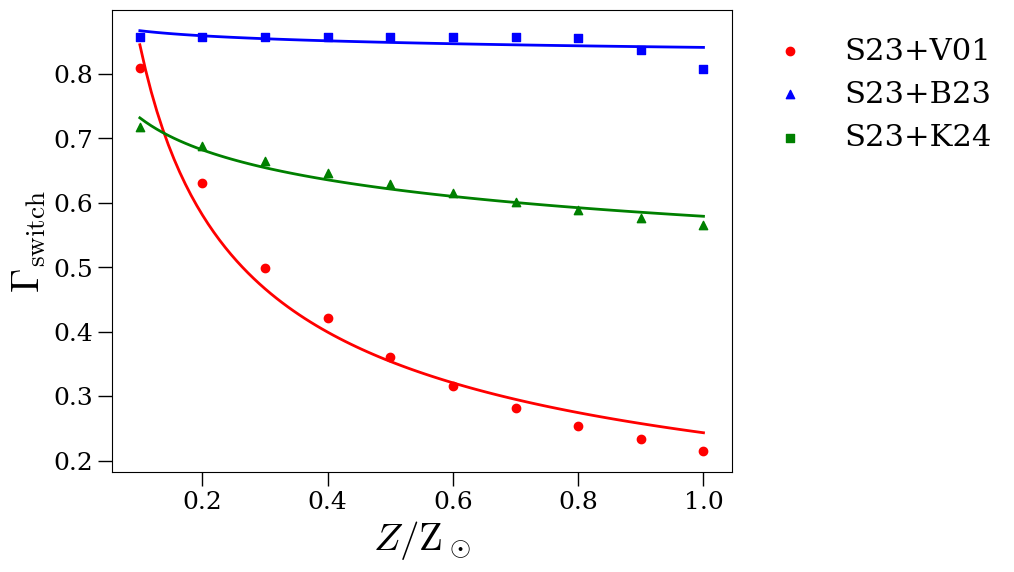

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
    
data = v01_fit_data
ax.scatter(data[:, 0], data[:, 1], color='r', marker='o')

data = b23_fit_data
ax.scatter(data[:, 0], data[:, 1], color='b', marker='s')

data = k24_fit_data
ax.scatter(data[:, 0], data[:, 1], color='g', marker='^')

handles, labels = ax.get_legend_handles_labels()
handles.append(ax.scatter([], [], color='r', marker='o', label='S23+V01'))
handles.append(ax.scatter([], [], color='b', marker='^', label='S23+B23'))
handles.append(ax.scatter([], [], color='g', marker='s', label='S23+K24'))

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

ax.set_ylabel('$\Gamma_\mathrm{switch}$')
ax.set_xlabel('$Z/\mathrm{Z}_\odot$')

plot_zs = np.linspace(0.1, 1, 100)
fit = v01_fit
ax.plot(plot_zs, fit[0]*plot_zs**fit[1], color='r')

fit = b23_fit
ax.plot(plot_zs, fit[0]*plot_zs**fit[1], color='b')

fit = k24_fit
ax.plot(plot_zs, fit[0]*plot_zs**fit[1], color='g')

Our fits are

In [23]:
v01_fit, k24_fit, b23_fit

(array([ 0.24320879, -0.54102601]),
 array([ 0.57911398, -0.10166527]),
 array([ 0.84116319, -0.01317803]))

In [24]:
print(f'For Teff={fit_t[0]} = 1e{np.log10(fit_t[0]):.2f}')

For Teff=44668.359215096345 = 1e4.65


For $T_\mathrm{eff}=45\,000\,\mathrm{K}=10^{4.65}\,\mathrm{K}$,

$$
\begin{align*}
\Gamma_{\mathrm{switch,V01}} = 0.243\left(\frac{Z}{\mathrm{Z}_\odot}\right)^{-0.541}, \\
\Gamma_{\mathrm{switch,K24}} = 0.585\left(\frac{Z}{\mathrm{Z}_\odot}\right)^{-0.016}, \\
\Gamma_{\mathrm{switch,B23}} = 0.838\left(\frac{Z}{\mathrm{Z}_\odot}\right)^{-0.099}.
\end{align*}
$$

For $T_\mathrm{eff}=50\,000\,\mathrm{K}=10^{4.70}\,\mathrm{K}$,

$$
\begin{align*}
\Gamma_{\mathrm{switch,V01}} = 0.243\left(\frac{Z}{\mathrm{Z}_\odot}\right)^{-0.541}, \\
\Gamma_{\mathrm{switch,K24}} = 0.701\left(\frac{Z}{\mathrm{Z}_\odot}\right)^{-0.056}, \\
\Gamma_{\mathrm{switch,B23}} = 0.766\left(\frac{Z}{\mathrm{Z}_\odot}\right)^{-0.072}.
\end{align*}
$$